# Credit scoring

The question is whether the marital status and the number of children of the client affects the fact of repayment of the loan on time. The results of the research will be taken into account when building a model of **credit scoring** — a special system that assesses the ability of a potential borrower to repay the loan to the bank.

## Data

Input data from the bank — statistics on the solvency of clients.
- children - number of children in the family
- days_employed - total length of service in days
- dob_years - client's age in years
- education - client's education level
- education_id - education level identifier
- family_status - marital status
- family_status_id - family status identifier
- gender - client's gender
- income_type - type of employment
- debt - whether the client had debts on repayment of loans
- total_income - monthly income
- purpose - purpose of loan

In [55]:
# Importing libraries
import pandas as pd
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt

In [56]:
# Retrieving data from a file
try:
    data = pd.read_csv('data.csv')
except:
    data = pd.read_csv('/datasets/data.csv')

In [57]:
data.head(10)

children  days_employed  dob_years  education  education_id  \
0         1   -8437.673028         42     higher             0   
1         1   -4024.803754         36  secondary             1   
2         0   -5623.422610         33  Secondary             1   
3         3   -4124.747207         32  secondary             1   
4         0  340266.072047         53  secondary             1   
5         0    -926.185831         27     higher             0   
6         0   -2879.202052         43     higher             0   
7         0    -152.779569         50  SECONDARY             1   
8         2   -6929.865299         35     HIGHER             0   
9         0   -2188.756445         41  secondary             1   

    family_status  family_status_id gender income_type  debt   total_income  \
0         married                 0      F    employee     0  253875.639453   
1         married                 0      F    employee     0  112080.014102   
2         married                 0      M    employee     0  145885.952297   
3         married                 0      M    employee     0  267628.550329   
4  civil marriage                 1      F   pensioner     0  158616.077870   
5  civil marriage                 1      M     partner     0  255763.565419   
6         married                 0      F     partner     0  240525.971920   
7         married                 0      M    employee     0  135823.934197   
8  civil marriage                 1      F    employee     0   95856.832424   
9         married                 0      M    employee     0  144425.938277   

                purpose  
0        buying a house  
1          buying a car  
2        buying a house  
3  additional education  
4  to perform a wedding  
5        buying a house  
6  housing transactions  
7             education  
8     to host a wedding  
9  family home purchase

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Data preprocessing

- The column names correspond to the universal form.
- The nature of fractional numbers in the days_employed and total_income columns is unclear.
- Negative numbers and outliers occur in the `days_employed` column.

### Filling gaps in the dataframe

In [59]:
# Looking for gaps in the numbers
print(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


<a id='match'></a>

In [60]:
print(data.loc[data['days_employed'].isna()].index.to_list()\
      == data.loc[data['total_income'].isna()].index.to_list()) 

True


From which we can conclude that the missing values in the two columns are matched row-wise.

In [61]:
gaps = data.loc[data['total_income'].isna()]

The income amount is most strongly influenced by employment type, so we can replace the gaps in the income amount with the median value for each type from the `income_type` column.

In [62]:
print(data['income_type'].value_counts())

employee              11119
partner                5085
pensioner              3856
civil servant          1459
unemployed                2
entrepreneur              2
student                   1
on maternity leave        1
Name: income_type, dtype: int64


In [63]:
print(data['total_income'].duplicated().sum())
print(data['total_income'].value_counts())

2173
169846.427535    1
105864.256244    1
228945.563612    1
72439.940645     1
132641.540844    1
                ..
155107.752145    1
160528.666287    1
160885.050715    1
100180.178296    1
189255.286637    1
Name: total_income, Length: 19351, dtype: int64


In [64]:
# Filling gaps in income with medians
data['total_income'] = data.groupby('income_type')['total_income']\
.transform(lambda x: x.fillna(x.median())) #  By default, skips NaN when counting
print(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64


In [65]:
print(data['total_income'].duplicated().sum())
print(data['total_income'].value_counts())

2172
142594.396847    1105
172357.950966     509
118514.486412     414
150447.935283     147
499163.144947       2
                 ... 
160528.666287       1
160885.050715       1
100180.178296       1
135607.236400       1
189255.286637       1
Name: total_income, Length: 19353, dtype: int64


These are the medians on the top.

Let's now examine the missing values in days of employment history.

In [66]:
print(data['days_employed'].duplicated().sum())
print(data['days_employed'].value_counts())
print(data['days_employed'].value_counts().sort_index())

2173
-327.685916       1
 375163.886753    1
-488.619642       1
 361900.083341    1
-4122.460569      1
                 ..
-667.873467       1
-1327.503350      1
-3347.946979      1
-871.839943       1
-3382.113891      1
Name: days_employed, Length: 19351, dtype: int64
-18388.949901     1
-17615.563266     1
-16593.472817     1
-16264.699501     1
-16119.687737     1
                 ..
 401663.850046    1
 401674.466633    1
 401675.093434    1
 401715.811749    1
 401755.400475    1
Name: days_employed, Length: 19351, dtype: int64


Artifacts among the numbers in the `days_employed` column include:
- negative numbers
- abnormally high numbers (1100 years is steep even for pensioners)

It is still unclear why the length of service is fractional. I can't help feeling that the `random.random()` method is involved in the process of obtaining data in the `days_employed` and `total_income` columns.

Let's change the sign of negative numbers:

In [67]:
# Fixing artifacts in the days_employed column: change signs
data['days_employed'] = abs(data['days_employed'])
data.head(10)

children  days_employed  dob_years  education  education_id  \
0         1    8437.673028         42     higher             0   
1         1    4024.803754         36  secondary             1   
2         0    5623.422610         33  Secondary             1   
3         3    4124.747207         32  secondary             1   
4         0  340266.072047         53  secondary             1   
5         0     926.185831         27     higher             0   
6         0    2879.202052         43     higher             0   
7         0     152.779569         50  SECONDARY             1   
8         2    6929.865299         35     HIGHER             0   
9         0    2188.756445         41  secondary             1   

    family_status  family_status_id gender income_type  debt   total_income  \
0         married                 0      F    employee     0  253875.639453   
1         married                 0      F    employee     0  112080.014102   
2         married                 0      M    employee     0  145885.952297   
3         married                 0      M    employee     0  267628.550329   
4  civil marriage                 1      F   pensioner     0  158616.077870   
5  civil marriage                 1      M     partner     0  255763.565419   
6         married                 0      F     partner     0  240525.971920   
7         married                 0      M    employee     0  135823.934197   
8  civil marriage                 1      F    employee     0   95856.832424   
9         married                 0      M    employee     0  144425.938277   

                purpose  
0        buying a house  
1          buying a car  
2        buying a house  
3  additional education  
4  to perform a wedding  
5        buying a house  
6  housing transactions  
7             education  
8     to host a wedding  
9  family home purchase

In [68]:
# Estimating labor histories by employment type by median:
print(data.groupby('income_type')['days_employed'].median())

income_type
civil servant           2689.368353
employee                1574.202821
entrepreneur             520.848083
on maternity leave      3296.759962
partner                 1547.382223
pensioner             365213.306266
student                  578.751554
unemployed            366413.652744
Name: days_employed, dtype: float64


Awe-inspiring numbers.

In [69]:
print(data['children'].unique())

[ 1  0  3  2 -1  4 20  5]


In [70]:
data.loc[data['children'] == -1]

children  days_employed  dob_years          education  education_id  \
291          -1    4417.703588         46          secondary             1   
705          -1     902.084528         50          secondary             1   
742          -1    3174.456205         57          secondary             1   
800          -1  349987.852217         54          secondary             1   
941          -1            NaN         57          Secondary             1   
1363         -1    1195.264956         55          SECONDARY             1   
1929         -1    1461.303336         38          secondary             1   
2073         -1    2539.761232         42          secondary             1   
3814         -1    3045.290443         26          Secondary             1   
4201         -1     901.101738         41          secondary             1   
4402         -1  398001.302888         64          SECONDARY             1   
4542         -1    1811.899756         32          secondary             1   
5272         -1    1143.485347         46          secondary             1   
6013         -1    1361.258696         46             higher             0   
6385         -1  370215.476226         48          secondary             1   
7190         -1    5928.202068         34          SECONDARY             1   
7278         -1     526.318451         51          secondary             1   
7615         -1            NaN         35          secondary             1   
7685         -1    3237.360455         53          secondary             1   
8229         -1    1803.441074         54             higher             0   
8251         -1    3113.998449         31          secondary             1   
8561         -1     195.479496         31          secondary             1   
9565         -1    2896.629686         34             higher             0   
9574         -1    2710.419901         28             higher             0   
10177        -1    1743.604011         37          secondary             1   
10365        -1  345774.125957         63             HIGHER             0   
10918        -1  340499.039342         50          secondary             1   
11109        -1    3438.463024         59          secondary             1   
11268        -1    1048.782203         30             higher             0   
11617        -1     370.827130         27          secondary             1   
12304        -1    8493.101252         61  incomplete higher             2   
13786        -1            NaN         42          secondary             1   
14357        -1     268.337037         23          secondary             1   
15147        -1    9851.184337         44          secondary             1   
15435        -1    3614.220232         40             higher             0   
16129        -1     457.861760         33          secondary             1   
16265        -1    2802.218127         40             higher             0   
17095        -1    2809.693200         34          secondary             1   
17429        -1     895.379738         37          secondary             1   
17657        -1    4571.957475         41          secondary             1   
18219        -1    3575.215641         33          secondary             1   
19100        -1     617.246968         38          secondary             1   
19366        -1     372.034749         43          SECONDARY             1   
19417        -1  350340.760224         28          secondary             1   
20393        -1  355157.107212         69          secondary             1   
20717        -1     661.822321         32             higher             0   
21140        -1    1422.668059         44          secondary             1   

        family_status  family_status_id gender    income_type  debt  \
291    civil marriage                 1      F       employee     0   
705           married                 0      F  civil servant     0   
742           married                 0      F   

In [71]:
data.loc[data['children'] == 20]

children  days_employed  dob_years  education  education_id  \
606          20     880.221113         21  secondary             1   
720          20     855.595512         44  secondary             1   
1074         20    3310.411598         56  secondary             1   
2510         20    2714.161249         59     higher             0   
2941         20    2161.591519          0  secondary             1   
...         ...            ...        ...        ...           ...   
21008        20    1240.257910         40  secondary             1   
21325        20     601.174883         37  secondary             1   
21390        20            NaN         53  secondary             1   
21404        20     494.788448         52  secondary             1   
21491        20     173.954460         27  secondary             1   

      family_status  family_status_id gender income_type  debt   total_income  \
606         married                 0      M     partner     0  145334.865002   
720         married                 0      F     partner     0  112998.738649   
1074        married                 0      F    employee     1  229518.537004   
2510        widowed                 2      F    employee     0  264474.835577   
2941        married                 0      F    employee     0  199739.941398   
...             ...               ...    ...         ...   ...            ...   
21008       married                 0      F    employee     1  133524.010303   
21325       married                 0      F     partner     0  102986.065978   
21390       married                 0      M     partner     0  172357.950966   
21404       married                 0      M     partner     0  156629.683642   
21491       married                 0      F    employee     0  155520.899688   

                                   purpose  
606                         buying a house  
720                   real estate purchase  
1074                educational attainment  
2510   commercial real estate transactions  
2941                          to buy a car  
...                                    ...  
21008                       own automobile  
21325                specialized education  
21390       buying residential real estate  
21404         own real estate transactions  
21491                    to buy a used car  

[76 rows x 12 columns]

In [72]:
data = data.loc[(data['children'] != -1) & (data['children'] != 20)]
print(data['children'].unique())

[1 0 3 2 4 5]


In [73]:
# Filling gaps in employment history with medians
data['days_employed'] = data.groupby('income_type')['days_employed']\
.transform(lambda x: x.fillna(x.median())) # Skips NaN when counting by default
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Removing duplicates

In [74]:
print(data.duplicated().sum())

54


In [75]:
data['total_income'] = data['total_income'].astype(int)
data.head(10)

children  days_employed  dob_years  education  education_id  \
0         1    8437.673028         42     higher             0   
1         1    4024.803754         36  secondary             1   
2         0    5623.422610         33  Secondary             1   
3         3    4124.747207         32  secondary             1   
4         0  340266.072047         53  secondary             1   
5         0     926.185831         27     higher             0   
6         0    2879.202052         43     higher             0   
7         0     152.779569         50  SECONDARY             1   
8         2    6929.865299         35     HIGHER             0   
9         0    2188.756445         41  secondary             1   

    family_status  family_status_id gender income_type  debt  total_income  \
0         married                 0      F    employee     0        253875   
1         married                 0      F    employee     0        112080   
2         married                 0      M    employee     0        145885   
3         married                 0      M    employee     0        267628   
4  civil marriage                 1      F   pensioner     0        158616   
5  civil marriage                 1      M     partner     0        255763   
6         married                 0      F     partner     0        240525   
7         married                 0      M    employee     0        135823   
8  civil marriage                 1      F    employee     0         95856   
9         married                 0      M    employee     0        144425   

                purpose  
0        buying a house  
1          buying a car  
2        buying a house  
3  additional education  
4  to perform a wedding  
5        buying a house  
6  housing transactions  
7             education  
8     to host a wedding  
9  family home purchase

In [76]:
print(data['education'].unique())

['higher' 'secondary' 'Secondary' 'SECONDARY' 'HIGHER' 'incomplete higher'
 'primary' 'Higher' 'INCOMPLETE HIGHER' 'Incomplete higher' 'PRIMARY'
 'Primary' 'Academic degree' 'ACADEMIC DEGREE' 'academic degree']


In [77]:
data['education'] = data['education'].replace(['Secondary', 'SECONDARY'], 'secondary')
data['education'] = data['education'].replace(['HIGHER', 'Higher'], 'higher')
data['education'] = data['education'].replace(['Incomplete higher', 'INCOMPLETE HIGHER'],\
                                              'incomplete higher')
data['education'] = data['education'].replace(['PRIMARY', 'Primary'], 'primary')
data['education'] = data['education'].replace(['Academic degree', 'ACADEMIC DEGREE'], 'academic degree')

# data['education'] = data['education'].str.lower() 
data['education'].unique()

array(['higher', 'secondary', 'incomplete higher', 'primary',
       'academic degree'], dtype=object)

In [78]:
# Let's make sure that there are no duplicates among the income types
print(data['income_type'].unique())

['employee' 'pensioner' 'partner' 'civil servant' 'unemployed'
 'entrepreneur' 'student' 'on maternity leave']


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21402 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  int64  
 11  purpose           21402 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB


In [80]:
data = data.drop_duplicates().reset_index(drop=True)
data.head()

children  days_employed  dob_years  education  education_id  \
0         1    8437.673028         42     higher             0   
1         1    4024.803754         36  secondary             1   
2         0    5623.422610         33  secondary             1   
3         3    4124.747207         32  secondary             1   
4         0  340266.072047         53  secondary             1   

    family_status  family_status_id gender income_type  debt  total_income  \
0         married                 0      F    employee     0        253875   
1         married                 0      F    employee     0        112080   
2         married                 0      M    employee     0        145885   
3         married                 0      M    employee     0        267628   
4  civil marriage                 1      F   pensioner     0        158616   

                purpose  
0        buying a house  
1          buying a car  
2        buying a house  
3  additional education  
4  to perform a wedding

In [81]:
print(data.duplicated().sum())

0


### Categorization

In [82]:
def total_income_category(income):
    if 0 <= income <= 30000:
        return 'E'
    elif 30001 <= income <= 50000:
        return 'D'
    elif 50001 <= income <= 200000:
        return 'C'
    elif 200001 <= income <= 1000000:
        return 'B'
    elif 1000001 <= income:
        return 'A'
    else:
        raise ValueError("income is not a positive integer")

In [83]:
data['total_income_category'] = data['total_income'].apply(total_income_category)
data.head()

children  days_employed  dob_years  education  education_id  \
0         1    8437.673028         42     higher             0   
1         1    4024.803754         36  secondary             1   
2         0    5623.422610         33  secondary             1   
3         3    4124.747207         32  secondary             1   
4         0  340266.072047         53  secondary             1   

    family_status  family_status_id gender income_type  debt  total_income  \
0         married                 0      F    employee     0        253875   
1         married                 0      F    employee     0        112080   
2         married                 0      M    employee     0        145885   
3         married                 0      M    employee     0        267628   
4  civil marriage                 1      F   pensioner     0        158616   

                purpose total_income_category  
0        buying a house                     B  
1          buying a car                     C  
2        buying a house                     C  
3  additional education                     B  
4  to perform a wedding                     C

In [84]:
data['purpose'].unique()

array(['buying a house', 'buying a car', 'additional education',
       'to perform a wedding', 'housing transactions', 'education',
       'to host a wedding', 'family home purchase',
       'real estate purchase', 'buying commercial real estate',
       'buying residential real estate', 'building your own real estate',
       'real estate', 'building real estate', 'to buy a used car',
       'to buy your own car', 'commercial real estate transactions',
       'construction of residential real estate', 'housing',
       'own real estate transactions', 'automobiles',
       'getting an education', 'used car deal', 'educational attainment',
       'automobile', 'wedding', 'further education',
       'buying your own house', 'real estate transactions',
       'getting higher education', 'own automobile',
       'automobile transaction', 'specialized education',
       'higher education', 'buying a house to rent', 'to buy a car',
       'home renovation', 'to pursue higher education'], dt

In [85]:
def categorize_purpose(purpose):
    if ' car' in purpose or 'automobile' in purpose:
        return 'car operations'
    elif 'hous' in purpose or 'home' in purpose or 'estate' in purpose:
        return 'real estate transactions'
    elif 'wedding' in purpose:
        return 'wedding organization'
    elif 'education' in purpose:
        return 'educational attainment'
    else:
        print(purpose)
        raise ValueError("unpredictable purpose")

In [86]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)
data.head()

children  days_employed  dob_years  education  education_id  \
0         1    8437.673028         42     higher             0   
1         1    4024.803754         36  secondary             1   
2         0    5623.422610         33  secondary             1   
3         3    4124.747207         32  secondary             1   
4         0  340266.072047         53  secondary             1   

    family_status  family_status_id gender income_type  debt  total_income  \
0         married                 0      F    employee     0        253875   
1         married                 0      F    employee     0        112080   
2         married                 0      M    employee     0        145885   
3         married                 0      M    employee     0        267628   
4  civil marriage                 1      F   pensioner     0        158616   

                purpose total_income_category          purpose_category  
0        buying a house                     B  real estate transactions  
1          buying a car                     C            car operations  
2        buying a house                     C  real estate transactions  
3  additional education                     B    educational attainment  
4  to perform a wedding                     C      wedding organization

## Search for correlation between data and credit debts

Let's check if the `debt` column contains binary values or number of debts.

In [87]:
print(data['debt'].unique())

[0 1]


Binary. Now to the correlation.

### Correlation between the number of children and the fact of indebtedness

In [88]:
data_by_children = data.groupby('children').agg({'debt': ['count', 'sum']})
data_by_children.columns = data_by_children.columns.droplevel() # Multi-index is inconvenient here
data_by_children

count   sum
children             
0         14091  1063
1          4808   444
2          2052   194
3           330    27
4            41     4
5             9     0

Let's find the proportion of people in debt by the number of children.

In [89]:
data_by_children['ratio'] = data_by_children['sum'] / data_by_children['count']
data_by_children['%'] = round(data_by_children['ratio'] * 100, 1)
print(data_by_children)

          count   sum     ratio    %
children                            
0         14091  1063  0.075438  7.5
1          4808   444  0.092346  9.2
2          2052   194  0.094542  9.5
3           330    27  0.081818  8.2
4            41     4  0.097561  9.8
5             9     0  0.000000  0.0


In [90]:
data.groupby('children')['debt'].mean()

children
0    0.075438
1    0.092346
2    0.094542
3    0.081818
4    0.097561
5    0.000000
Name: debt, dtype: float64

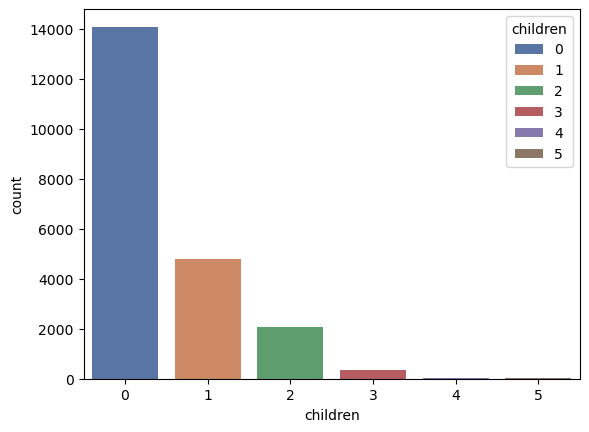

In [91]:
sb.barplot(data=data_by_children, x=data_by_children.index, y='count', hue=data_by_children.index, palette='deep')
plt.show()

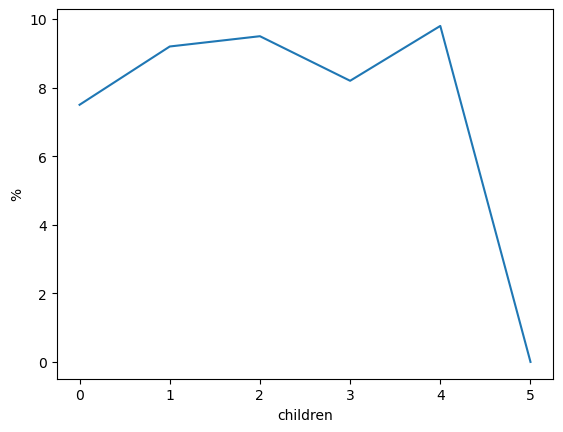

In [92]:
sb.lineplot(data=data_by_children, x='children', y='%')
plt.show()

At first glance there could be a link (growth of more than 1.5%). The decline among clients with 3 children can be explained by the small sample size (330 people).

In [93]:
data_by_children['count_ratio'] = data_by_children['count'] / data_by_children['count'].sum()
data_by_children['sum_ratio'] = data_by_children['sum'] / data_by_children['sum'].sum()
print(data_by_children)

          count   sum     ratio    %  count_ratio  sum_ratio
children                                                    
0         14091  1063  0.075438  7.5     0.660588   0.613741
1          4808   444  0.092346  9.2     0.225400   0.256351
2          2052   194  0.094542  9.5     0.096198   0.112009
3           330    27  0.081818  8.2     0.015470   0.015589
4            41     4  0.097561  9.8     0.001922   0.002309
5             9     0  0.000000  0.0     0.000422   0.000000


It seems that borrowers without children repay debts more often than clients who have children. Apparently, this has a significant impact on the financial capacity of a potential client.  
However, we do not have enough data on some groups of borrowers.

### Correlation between marital status and the fact of indebtedness

Following the same steps.

In [94]:
print(data['family_status'].unique())

['married' 'civil marriage' 'widowed' 'divorced' 'single']


In [95]:
data_by_status = data.groupby('family_status').agg({'debt': ['count', 'sum']})

data_by_status.columns = data_by_status.columns.droplevel()
print(data_by_status)

                count  sum
family_status             
civil marriage   4134  385
divorced         1189   84
married         12261  927
single           2796  273
widowed           951   63


In [96]:
data_by_status['ratio'] = data_by_status['sum'] / data_by_status['count']
data_by_status['%'] = round(data_by_status['ratio'] * 100, 1)
print(data_by_status.sort_values(by='%', ascending=False))

                count  sum     ratio    %
family_status                            
single           2796  273  0.097639  9.8
civil marriage   4134  385  0.093130  9.3
married         12261  927  0.075606  7.6
divorced         1189   84  0.070648  7.1
widowed           951   63  0.066246  6.6


The difference in numbers is significant, although I cannot find a logical distinction between `married` and `common-law marriage` (whereas the numbers do), so in my opinion there may not be a correlation.

Even more contrasting is the difference between unmarried clients and divorced clients: the former repay loans 2.7% less often than the latter, although the difference between these groups is not obvious.

In [97]:
print(data.loc[data['family_status'] == 'Не женат / не замужем']['dob_years'].mean())
print(data.loc[data['family_status'] == 'в разводе']['dob_years'].mean())

nan
nan


The difference in average age is not so big.

In [98]:
print(len(data.loc[(data['children'] == 0) & (data['family_status'] == 'женат / замужем')])\
          / len(data))

0.0


Let's note that more than a third of clients are married without children.

### The relationship between income level and the fact of indebtedness

We will look for dependence by income categories.

In [99]:
print(data.columns)

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose', 'total_income_category', 'purpose_category'],
      dtype='object')


In [100]:
data_by_income = data.groupby('total_income_category').agg({'debt': ['count', 'sum']})

data_by_income.columns = data_by_income.columns.droplevel()
print(data_by_income)

                       count   sum
total_income_category             
A                         25     2
B                       5014   354
C                      15921  1353
D                        349    21
E                         22     2


In [101]:
data_by_income['ratio'] = data_by_income['sum'] / data_by_income['count']
data_by_income['%'] = round(data_by_income['ratio'] * 100, 1)
print(data_by_income.sort_values(by='%', ascending=False))

                       count   sum     ratio    %
total_income_category                            
E                         22     2  0.090909  9.1
C                      15921  1353  0.084982  8.5
A                         25     2  0.080000  8.0
B                       5014   354  0.070602  7.1
D                        349    21  0.060172  6.0


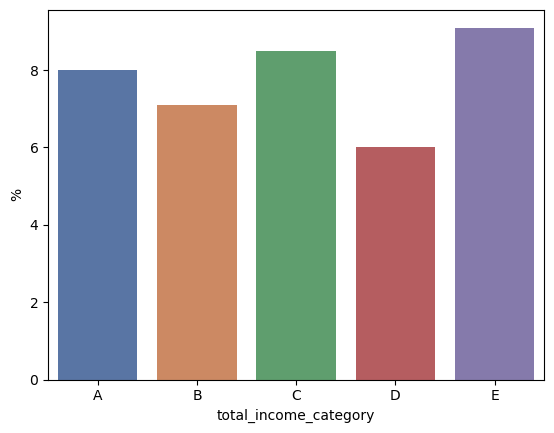

In [102]:
sb.barplot(data=data_by_income, x=data_by_income.index, y='%', hue=data_by_income.index, palette='deep')
plt.show()

For the outermost categories, there is insufficient data to draw conclusions, but the difference between the 50,001 to 200,000 (8.5%) and 200,001 to 1,000,000 (7.1%) categories is plausible.

### The relationship between the purpose of taking a loan and the fact of its repayment

In [103]:
data_by_purpose = data.groupby('purpose_category').agg({'debt': ['count', 'sum']})

data_by_purpose.columns = data_by_purpose.columns.droplevel()
print(data_by_purpose)

                          count  sum
purpose_category                    
car operations             4279  400
educational attainment     3988  369
real estate transactions  10751  780
wedding organization       2313  183


In [104]:
data_by_purpose['ratio'] = data_by_purpose['sum'] / data_by_purpose['count']
data_by_purpose['%'] = round(data_by_purpose['ratio'] * 100, 1)
print(data_by_purpose.sort_values(by='%', ascending=False))

                          count  sum     ratio    %
purpose_category                                   
car operations             4279  400  0.093480  9.3
educational attainment     3988  369  0.092528  9.3
wedding organization       2313  183  0.079118  7.9
real estate transactions  10751  780  0.072551  7.3


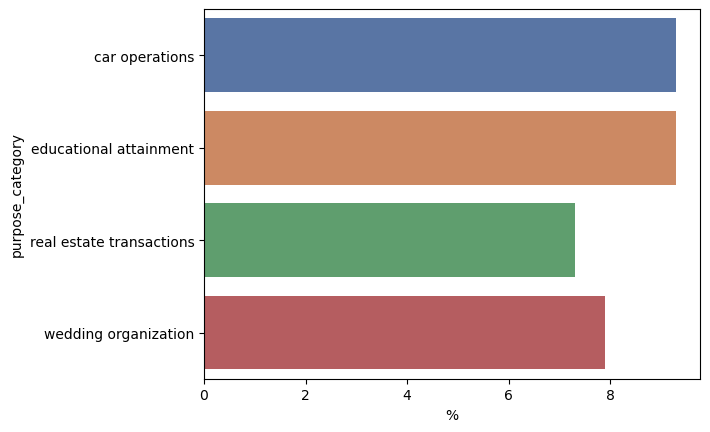

In [105]:
sb.barplot(data=data_by_purpose, y=data_by_purpose.index, x='%', orient='h', hue=data_by_purpose.index, palette='deep')
plt.show()

There is enough data here to draw conclusions for all categories. For example, loans for real estate transactions or weddings are repaid more often than loans for education or car purchases.

### Possible causes of missing values in data

As shown [previously](#match), the gaps in income numbers and the labor history are completely overlapping, from which we can conclude that they are non-random.

In [106]:
print(gaps['income_type'].value_counts())

employee         1105
partner           508
pensioner         413
civil servant     147
entrepreneur        1
Name: income_type, dtype: int64


As you can see, none of these people described themselves as unemployed.

In [107]:
data_with_gaps = gaps.groupby('income_type').agg({'debt': ['count', 'sum']})

data_with_gaps.columns = data_with_gaps.columns.droplevel()
print(data_with_gaps)

               count  sum
income_type              
civil servant    147    7
employee        1105   98
entrepreneur       1    0
partner          508   30
pensioner        413   35


In [108]:
data_with_gaps['ratio'] = data_with_gaps['sum'] / data_with_gaps['count']
data_with_gaps['%'] = round(data_with_gaps['ratio'] * 100, 1)
print(data_with_gaps.sort_values(by='%', ascending=False))

               count  sum     ratio    %
income_type                             
employee        1105   98  0.088688  8.9
pensioner        413   35  0.084746  8.5
partner          508   30  0.059055  5.9
civil servant    147    7  0.047619  4.8
entrepreneur       1    0  0.000000  0.0


Loan default rates are no higher than average, so it's unlikely that income is not reported with any hidden intent.

I think these customers just didn't want to list their place of employment (if that option is allowed by the bank).

According to the probable randomness of these people, the gaps are to be filled by the median value within each income group. The arithmetic mean works worse in this case, because even within a group there can be outliers, and the median is more robust than the mean.

## Conclusions

1. Difference between childless clients and those who do have 1 or 2 children is present: 7.5% non-return vs. 9.2% and 9.5% respectively. There is not enough data to draw conclusions for clients with 3, 4 and 5 children.
2. In terms of marital status, low arrears rates for widows/widowers and divorced (6.6% and 7.1%) can be noted. Elsewhere, a logical connection is poorly sought.
3. People with incomes between 50,001 and 200,000 repay loans less often (8.5%) than people with incomes between 200,001 and 1,000,000. However, the nature of these **fractional** numbers is not clear to me. Especially for students and pensioners. I would check how the numbers of income and work experience were obtained and calculated.
4. A fairly clear picture emerges in terms of the purpose of taking a loan. Car and education loans are repaid less often than wedding and real estate loans (9.3% and 9.3% vs. 7.9% and 7.3%).